In [1]:
import torch
from datasets.mnist import MNIST
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torchvision
import os
from ipywidgets import interact, FloatSlider
import pandas as pd
import numpy as np


from nn.enforced_ae import EnforcedAE
from nn.ae import AE
from train import train
from schedule import cosine_schedule


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   


In [2]:
train_dataset = MNIST(root='../../datasets', split='train', download=False, device=device, normalize=False, augment=True)
val_dataset = MNIST(root='../../datasets', split='val', download=False, device=device, normalize=False)
test_dataset = MNIST(root='../../datasets', split='test', download=False, device=device, normalize=False)

  6%|▌         | 3105/54000 [00:00<00:01, 31039.08it/s]

In [90]:
experiment_name = 'base'
trial_name = 'ae_cnn20_schedules'
load=True

model = AE(in_channels=1, z_dim=20, cnn=True).to(device)

if load:
    model.load_state_dict(torch.load(f'out/models/{experiment_name}/{trial_name}/run_0.pt'))
else:

    optimiser = torch.optim.AdamW(model.parameters(), lr=1e-3)
    num_epochs = 200
    batch_size = 256
    compute_dtype = torch.bfloat16

    hyperparams = {
        'lr': cosine_schedule(base=1e-3, end=1e-4, T=num_epochs, warmup=10, flat_end=10),
        'wd': cosine_schedule(base=0.004, end=0.1, T=num_epochs)
    }

    trial_log_dir = f'out/logs/{experiment_name}/{trial_name}'
    run_no = 0
    while os.path.exists(trial_log_dir + f'/run_{run_no}'):
        run_no += 1
    writer = SummaryWriter(trial_log_dir + f'/run_{run_no}')
    save_dir = f'out/models/{experiment_name}/{trial_name}/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_dir=save_dir + f'run_{run_no}.pt'


    train(model, train_dataset, val_dataset, optimiser, num_epochs=num_epochs, batch_size=batch_size, writer=writer, compute_dtype=compute_dtype, save_dir=save_dir, epoch_hyperparams=hyperparams)

/tmp/ipykernel_267107/2274956900.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'out/models/{experiment_name}/{trial_name}/run_0.pt'))

In [3]:
experiment_name = 'base'
trial_name = 'base_cnn20_schedules'
load=True

model = EnforcedAE(in_channels=1, z_dim=20, cnn=True).to(device)

if load:
    model.load_state_dict(torch.load(f'out/models/{experiment_name}/{trial_name}/run_0.pt'))
else:

    optimiser = torch.optim.AdamW(model.parameters(), lr=1e-3)
    num_epochs = 200
    batch_size = 256
    compute_dtype = torch.bfloat16

    hyperparams = {
        'lr': cosine_schedule(base=1e-3, end=1e-4, T=num_epochs, warmup=10, flat_end=10),
        'wd': cosine_schedule(base=0.004, end=0.1, T=num_epochs)
    }

    trial_log_dir = f'out/logs/{experiment_name}/{trial_name}'
    run_no = 0
    while os.path.exists(trial_log_dir + f'/run_{run_no}'):
        run_no += 1
    writer = SummaryWriter(trial_log_dir + f'/run_{run_no}')
    save_dir = f'out/models/{experiment_name}/{trial_name}/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_dir=save_dir + f'run_{run_no}.pt'


    train(model, train_dataset, val_dataset, optimiser, num_epochs=num_epochs, batch_size=batch_size, writer=writer, compute_dtype=compute_dtype, save_dir=save_dir, epoch_hyperparams=hyperparams)

/tmp/ipykernel_328474/1913448453.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'out/models/{experiment_name}/{trial_name}/run_0.pt'))

Latent Variable Transformation
             z0       rotation
             z1    translate x
             z2    translate y
             z3          scale
             z4          shear


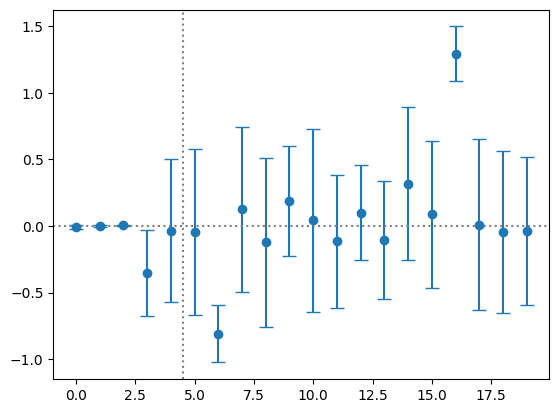

In [7]:
embeddings = model.infer(test_dataset.images).detach()
means = embeddings.mean(dim=0)
stds = embeddings.std(dim=0)

plt.errorbar(range(20), means.cpu(), yerr=stds.cpu(), fmt='o', capsize=5)
plt.axhline(0.0, linestyle='dotted', color='gray')
plt.axvline(4.5, linestyle='dotted', color='gray')
import pandas as pd

# Create a DataFrame with the required information
df = pd.DataFrame({
    'Latent Variable': ['z0', 'z1', 'z2', 'z3', 'z4'],
    'Transformation': ['rotation', 'translate x', 'translate y', 'scale', 'shear']
})

# Display the table
print(df.to_string(index=False))

plt.show()


Val Loss: 79.8157: 100%|██████████| 30/30 [01:11<00:00,  2.39s/it]


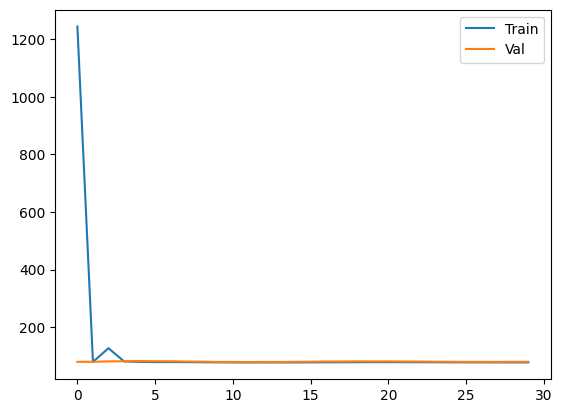

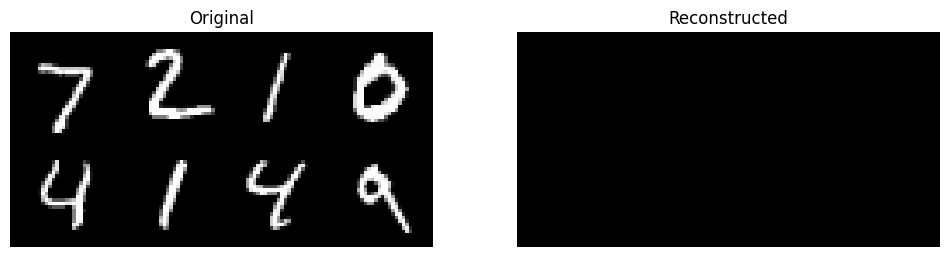

In [15]:
import torch.nn.functional as F
from tqdm import tqdm
from nn.modules.cnn import ConvDecoder
decoder = ConvDecoder(in_dim=15).to(device)
optimiser = torch.optim.AdamW(decoder.parameters(), lr=1e-3)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True) 
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

loop = tqdm(range(30))
train_losses = []
val_losses = []
for _ in loop:
    optimiser.zero_grad()
    epoch_train_losses = []
    for images, _ in train_loader:
        images = images.to(device)
        z = model.infer(images)[:, 5:]
        images_hat = decoder(z)
        loss = model.recon_loss(images, images_hat).mean()
        epoch_train_losses.append(loss.item())
        loss.backward()
        optimiser.step()
    train_losses.append(np.mean(epoch_train_losses))

    epoch_val_losses = []
    for images, _ in val_loader:
        images = images.to(device)
        z = model.infer(images)[:, 5:]
        images_hat = decoder(z)
        loss = model.recon_loss(images, images_hat).mean()
        epoch_val_losses.append(loss.item())
    val_losses.append(np.mean(epoch_val_losses))
    loop.set_description(f"Val Loss: {val_losses[-1]:.4f}")


plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.legend()
plt.show()

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

images, _= next(iter(test_loader))

z = model.infer(images)[:, 5:]
reconstructions = decoder(z).detach()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(torchvision.utils.make_grid(images.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(torchvision.utils.make_grid(reconstructions.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
axes[1].set_title('Reconstructed')
axes[1].axis('off')

plt.show()

/tmp/ipykernel_326883/92562766.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'out/models/{experiment_name}/{trial_name}/run_0.pt'))


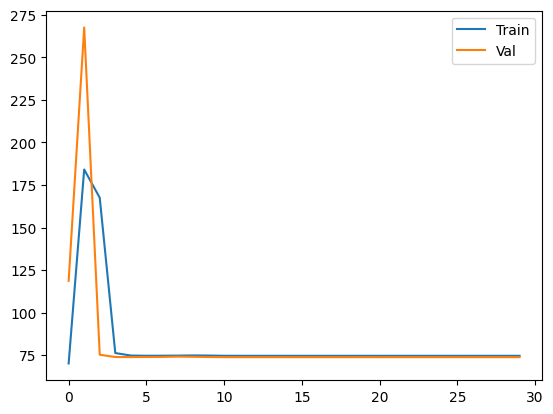

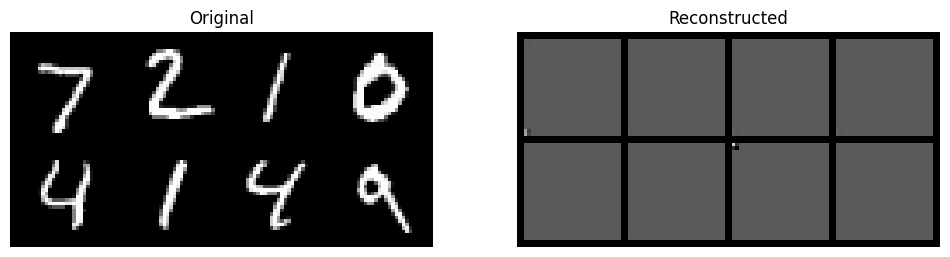

In [17]:
import torch.nn.functional as F
from tqdm import tqdm
from nn.modules.cnn import ConvDecoder
decoder = ConvDecoder(in_dim=20).to(device)
optimiser = torch.optim.AdamW(decoder.parameters(), lr=1e-3)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True) 
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

experiment_name = 'base'
trial_name = 'ae_cnn20_schedules'
load=True

model = AE(in_channels=1, z_dim=20, cnn=True).to(device)
model.load_state_dict(torch.load(f'out/models/{experiment_name}/{trial_name}/run_0.pt'))
lrs = cosine_schedule(base=1e-3, end=1e-4, T=30, warmup=10, flat_end=10)

loop = tqdm(range(30))
train_losses = []
val_losses = []
for i in loop:
    optimiser.zero_grad()
    epoch_train_losses = []
    
    for param_group in optimiser.param_groups:
        param_group['lr'] = lrs[i]

    for images, _ in train_loader:
        images = images.to(device)
        z = model.infer(images)
        images_hat = decoder(z)
        loss = model.recon_loss(images, images_hat).mean()
        epoch_train_losses.append(loss.item())
        loss.backward()
        optimiser.step()
    train_losses.append(np.mean(epoch_train_losses))

    epoch_val_losses = []
    for images, _ in val_loader:
        images = images.to(device)
        z = model.infer(images)
        images_hat = decoder(z)
        loss = model.recon_loss(images, images_hat).mean()
        epoch_val_losses.append(loss.item())
    val_losses.append(np.mean(epoch_val_losses))
    loop.set_description(f"Val Loss: {val_losses[-1]:.4f}")


plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.legend()
plt.show()


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

images, _= next(iter(test_loader))

z = model.infer(images)
reconstructions = decoder(z).detach()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(torchvision.utils.make_grid(images.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(torchvision.utils.make_grid(reconstructions.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
axes[1].set_title('Reconstructed')
axes[1].axis('off')

plt.show()

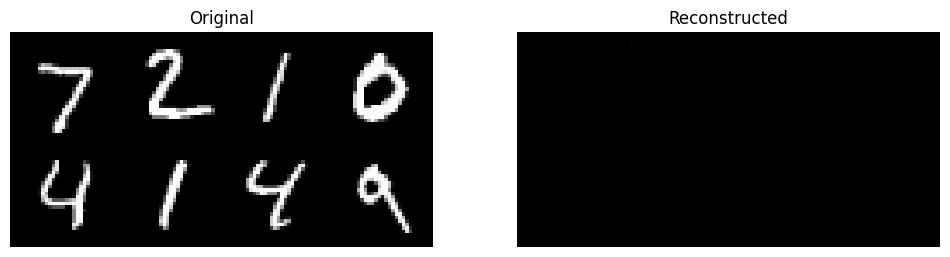

In [13]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

images, _= next(iter(test_loader))

z = model.infer(images)
reconstructions = decoder(z).detach()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(torchvision.utils.make_grid(images.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(torchvision.utils.make_grid(reconstructions.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
axes[1].set_title('Reconstructed')
axes[1].axis('off')

plt.show()

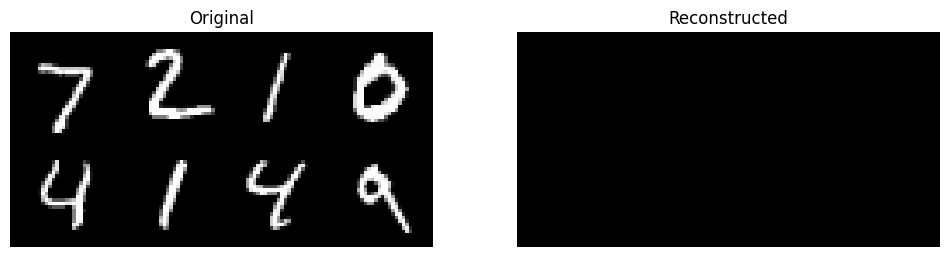

In [7]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

images, _= next(iter(test_loader))

z = model.infer(images)[:, 5:]
reconstructions = decoder(z).detach()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(torchvision.utils.make_grid(images.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(torchvision.utils.make_grid(reconstructions.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
axes[1].set_title('Reconstructed')
axes[1].axis('off')

plt.show()

In [100]:
# OFFSET LATENTS
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

images, _= next(iter(test_loader))
z = model.infer(images)
def plot_images_with_widgets(model, images):
    def update(z0=0., z1=0., z2=0., z3=0., z4=0.):
        latents = z.clone().detach()
        latents[:, :5] = torch.tensor([z0, z1, z2, z3, z4]).to(device)
        # images_hat = model.decode(latents).detach()
        images_hat = model.transform_images(images, torch.tensor([z0, z1, z2, z3, z4]).to(device))[0]

        import matplotlib.pyplot as plt

        # Plot original images
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(torchvision.utils.make_grid(images.cpu(), nrow=1, padding=2, normalize=True).permute(1, 2, 0))
        axes[0].set_title('Input')
        axes[0].axis('off')

        axes[1].imshow(torchvision.utils.make_grid(images_hat.cpu(), nrow=1, padding=2, normalize=True).permute(1, 2, 0))
        axes[1].set_title('Target')
        axes[1].axis('off')

        plt.show()
    
    interact(update, 
             z0=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,0].item(), description='rotation'),
             z1=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,1].item(), description='x offset'),
             z2=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,2].item(), description='y offset'),
             z3=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,3].item(), description='scale'),
             z4=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,4].item(), description='shear'))

plot_images_with_widgets(model, images)

interactive(children=(FloatSlider(value=-7.502201333409175e-05, description='rotation', max=3.0, min=-3.0), Fl…

In [ ]:

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

images, _= next(iter(test_loader))
def plot_images_with_widgets(model, images):
    def update(rotation=0., translate_x=0., translate_y=0., scale=1., shear=0.):
        action = torch.tensor([rotation, translate_x, translate_y, scale, shear]).to(device)
        images_aug, actions = model.transform_images(images, action)
        images_hat = model(images, action)[0]

        import matplotlib.pyplot as plt

        # Plot original images
        fig, axes = plt.subplots(1, 3, figsize=(12, 6))
        axes[0].imshow(torchvision.utils.make_grid(images.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
        axes[0].set_title('Original Inputs')
        axes[0].axis('off')

        axes[1].imshow(torchvision.utils.make_grid(images_aug.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
        axes[1].set_title('Transformed Targets')
        axes[1].axis('off')

        axes[2].imshow(torchvision.utils.make_grid(images_hat.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
        axes[2].set_title('Output Predictions')
        axes[2].axis('off')

        plt.show()
    
    interact(update, 
             rotation=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.),
             translate_x=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.),
             translate_y=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.),
             scale=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.),
             shear=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.))

plot_images_with_widgets(model, images)

In [11]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

images, _= next(iter(test_loader))
def plot_images_with_widgets(model, images):
    latents = model.infer(images)
    def update(rotation=0., translate_x=0., translate_y=0., scale=1., shear=0.):
        action = torch.tensor([rotation, translate_x, translate_y, scale, shear]).to(device)
        images_aug, actions = model.transform_images(images, action)
        images_hat = model(images, action)[0]

        import matplotlib.pyplot as plt

        # Plot original images
        fig, axes = plt.subplots(1, 3, figsize=(12, 6))
        axes[0].imshow(torchvision.utils.make_grid(images.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
        axes[0].set_title('Original Inputs')
        axes[0].axis('off')

        axes[1].imshow(torchvision.utils.make_grid(images_aug.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
        axes[1].set_title('Transformed Targets')
        axes[1].axis('off')

        axes[2].imshow(torchvision.utils.make_grid(images_hat.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
        axes[2].set_title('Output Predictions')
        axes[2].axis('off')

        plt.show()
    
    interact(update, 
             rotation=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.),
             translate_x=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.),
             translate_y=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.),
             scale=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.),
             shear=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.))

plot_images_with_widgets(model, images)

interactive(children=(FloatSlider(value=0.0, description='rotation', max=1.0, min=-1.0), FloatSlider(value=0.0…

In [92]:

def plot_images_with_widgets(model):
    idx = torch.randint(0, len(test_dataset), (1,))
    image = test_dataset[idx][0]
    z = model.infer(image)
    def update(z0=0., z1=0., z2=0., z3=0., z4=0., z5=0., z6=0., z7=0., z8=0., z9=0.):
        z[:, :10] = torch.tensor([z0, z1, z2, z3, z4, z5, z6, z7, z8, z9])
        x_hat = model.decode(z).detach()
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(image.cpu().squeeze(0).permute(1, 2, 0), cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(x_hat.cpu().squeeze(0).permute(1, 2, 0), cmap='gray')
        axes[1].set_title('Reconstructed Image')
        axes[1].axis('off')

        plt.show()

    sliders = {
        
        'z0': FloatSlider(min=-3.0, max=3.0, step=0.01, value=z[:,0].item()),
        'z1': FloatSlider(min=-3.0, max=3.0, step=0.01, value=z[:,1].item()),
        'z2': FloatSlider(min=-3.0, max=3.0, step=0.01, value=z[:,2].item()),
        'z3': FloatSlider(min=-3.0, max=3.0, step=0.01, value=z[:,3].item()),
        'z4': FloatSlider(min=-3.0, max=3.0, step=0.01, value=z[:,4].item()),
        'z5': FloatSlider(min=-3.0, max=3.0, step=0.01, value=z[:,5].item()),
        'z6': FloatSlider(min=-3.0, max=3.0, step=0.01, value=z[:,6].item()),
        'z7': FloatSlider(min=-3.0, max=3.0, step=0.01, value=z[:,7].item()),
        'z8': FloatSlider(min=-3.0, max=3.0, step=0.01, value=z[:,8].item()),
        'z9': FloatSlider(min=-3.0, max=3.0, step=0.01, value=z[:,9].item()),
    }

    interact(update, **sliders)

plot_images_with_widgets(model)

interactive(children=(FloatSlider(value=-1.7956098318099976, description='z0', max=3.0, min=-3.0, step=0.01), …